In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

## Data Loading

In [2]:
DATA_IN_PATH='./data_in/'
DATA_OUT_PATH='./data_out/'
INPUT_TRAIN_DATA='nsmc_train_input.npy'
LABEL_TRAIN_DATA='nsmc_train_label.npy'
DATA_CONFIGS='data_configs.json'


train_input = np.load(open(DATA_IN_PATH+INPUT_TRAIN_DATA,'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH+LABEL_TRAIN_DATA,'rb'))
prepro_configs = json.load(open(DATA_IN_PATH+DATA_CONFIGS,'r'))


SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [3]:
train_input[:5]

array([[   64,   475,    27,   276,   678,     0,     0,     0],
       [  617,     2,   230,  1473,    37,   983,   694,    31],
       [ 2470, 25042,  2337,  5694,     3,   237,    21,    19],
       [  121,  8151,   235,    70,    11,    14,    38,  3635],
       [  255,     4, 14273, 19444,     7,  1097,   270,   255]])

In [4]:
train_label[:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [5]:
prepro_configs['vocab_size']

43771

## Define Model

In [6]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE=256
NUM_EPOCHS = 10
VALID_SPLIT=0.1
MAX_LEN = train_input.shape[1]

kargs = {
    'model_name':model_name, 
    'vocab_size':prepro_configs['vocab_size'],
    'embedding_size':128,
    'num_filters':100,
    'dropout_rate':0.5,
    'hidden_dimension':100,
    'output_dimension':1}

In [7]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self,**kargs):
        super(CNNClassifier,self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_size'])
        self.conv_list = [ 
            layers.Conv1D(
                filters=kargs['num_filters'],
                kernel_size=kernel_size,
                padding='valid',
                activation=tf.keras.activations.relu, 
                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)
            )
        for kernel_size in [3,4,5]]
        
        self.pooling = layers.GlobalMaxPool1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(
            units=kargs['hidden_dimension'],
            activation=tf.keras.activations.relu, 
            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(
            units=kargs['output_dimension'],
            activation=tf.keras.activations.sigmoid, 
            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self,x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list],axis=-1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

## Create Model

In [8]:
model = CNNClassifier(**kargs)

model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [9]:
earlystop_callback = EarlyStopping(monitor='val_accuracy',min_delta = 0.0001, patience = 2)

checkpoint_path = DATA_OUT_PATH + model_name+'/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already Exists\n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir,exist_ok=True)
    print("{} -- Folder create complete\n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor="val_accuracy", verbose=1, save_best_only=True,save_weights_only=True)

./data_out/cnn_classifier_kr -- Folder already Exists



In [10]:
history = model.fit(
    train_input, 
    train_label,
    batch_size=BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_split=VALID_SPLIT,
    callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
528/528 [==============================] - 44s 78ms/step - loss: 0.5221 - accuracy: 0.7223 - val_loss: 0.3911 - val_accuracy: 0.8222

Epoch 00001: val_accuracy improved from -inf to 0.82220, saving model to ./data_out/cnn_classifier_kr\weights.h5
Epoch 2/10
528/528 [==============================] - 40s 75ms/step - loss: 0.3550 - accuracy: 0.8432 - val_loss: 0.3912 - val_accuracy: 0.8249

Epoch 00002: val_accuracy improved from 0.82220 to 0.82487, saving model to ./data_out/cnn_classifier_kr\weights.h5
Epoch 3/10
528/528 [==============================] - 40s 75ms/step - loss: 0.2975 - accuracy: 0.8750 - val_loss: 0.4053 - val_accuracy: 0.8228

Epoch 00003: val_accuracy did not improve from 0.82487
Epoch 4/10
528/528 [==============================] - 40s 75ms/step - loss: 0.2520 - accuracy: 0.8937 - val_loss: 0.4383 - val_accuracy: 0.8211

Epoch 00004: val_accuracy did not improve from 0.82487
Epoch 5/10
528/528 [==============================] - 40s 76ms/step - loss: 0.217

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

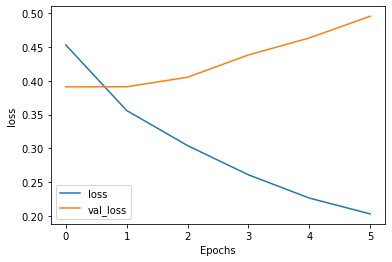

In [12]:
plot_graphs(history,'loss')

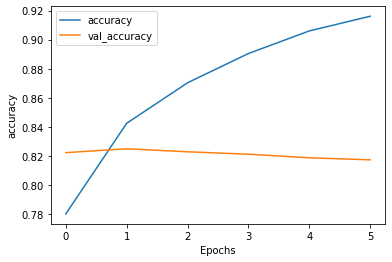

In [13]:
plot_graphs(history,'accuracy')

In [15]:
DATA_OUT_PATH  ='./data_out/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM='weights.h5'

test_input = np.load(open(DATA_IN_PATH+INPUT_TEST_DATA,'rb'))
test_input = pad_sequences(test_input, maxlen = test_input.shape[1])
test_label_data = np.load(open(DATA_IN_PATH+LABEL_TEST_DATA,'rb'))
model.load_weights(os.path.join(DATA_OUT_PATH,model_name,SAVE_FILE_NM))
model.evaluate(test_input,test_label_data)

1563/1563 [==============================] - 6s 4ms/step - loss: 0.3920 - accuracy: 0.8247


[0.39200249314308167, 0.824679970741272]